In [2]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow import keras

import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statistics


from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import StackingClassifier
import shap

2023-07-25 19:01:50.010345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_26227/4004419006.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
data = pd.read_csv("data/data_preds.csv", index_col = 0)
data = data.drop(columns = 'Date')
data = data.dropna(axis = 1)
data.shape


(2347, 270)

In [5]:
X = data.drop(columns = 'K')
y = data['K']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.7, random_state = 123)

In [6]:

cat_feats = ['Team_x', 'Opp']
num_feats = X.drop(columns = ['Team_x', 'Opp']).columns.tolist()

In [7]:
ct = make_column_transformer(
    (StandardScaler(), num_feats),
    (OneHotEncoder(handle_unknown = 'ignore'), cat_feats))
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['W', 'L', 'WAR_x', 'ERA', 'CG', 'ShO', 'IP',
                                  'TBF', 'H_x', 'R_x', 'ER', 'HR_x', 'BB_x',
                                  'IBB_x', 'HBP_x', 'WP', 'BK', 'SO_x', 'GB_x',
                                  'FB_x', 'LD_x', 'IFFB_x', 'Balls_x',
                                  'Strikes_x', 'Pitches_x', 'RS', 'IFH_x',
                                  'BU_x', 'BUH_x', 'K/9', ...]),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Team_x', 'Opp'])])

In [8]:
transformed_x_train = ct.fit_transform(X_train)
transformed_x_val = ct.transform(X_val)
transformed_x_test = ct.transform(X_test)

In [9]:
colnames = num_feats + list(ct.named_transformers_['onehotencoder'].get_feature_names_out())

In [10]:
X_train_transformed = pd.DataFrame(transformed_x_train, columns = colnames)
X_val_transformed = pd.DataFrame(transformed_x_val, columns = colnames)
X_test_transformed = pd.DataFrame(transformed_x_test, columns = colnames)
n_features = len(colnames)

In [61]:
def build_model(hp):
  model = Sequential()
  counter = 0
  for i in range(hp.Int('num_layers',min_value=1,max_value=30)):
    if counter == 0:
      model.add(Dense(hp.Int('units' + str(i), min_value=8, max_value=300,step=8),activation= hp.Choice('activation' + str(i), values=['relu','tanh','sigmoid']),input_dim=n_features))
      model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6])))
    else:
      model.add(Dense(hp.Int('units' + str(i), min_value=8, max_value=270,step=4),activation= hp.Choice('activation' + str(i), values=['relu','tanh','sigmoid'])))
      model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6])))
    counter+=1
  model.add(Dense(1,activation='linear'))
  model.compile(optimizer=hp.Choice('optimizer',values=['adagrad','adam','sgd']),
                  loss='mse',
                  metrics=[MeanSquaredError()])
  return model

tuner = kt.Hyperband(build_model, objective = 'val_mean_squared_error', max_epochs = 100, overwrite = True)
tuner.search(X_train_transformed, y_train, epochs = 100, validation_data = (X_val_transformed, y_val))
print(tuner.get_best_hyperparameters()[0].values)
model = tuner.get_best_models()[0]
es = EarlyStopping(monitor = 'val_loss', patience = 10)
model.fit(X_train_transformed, y_train, epochs = 100, verbose = 2, validation_split = 0.3, callbacks = [es])
model.save("models/K_model")

Trial 254 Complete [00h 00m 12s]
val_mean_squared_error: 6.070514678955078

Best val_mean_squared_error So Far: 4.360710144042969
Total elapsed time: 00h 12m 54s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 4, 'units0': 256, 'activation0': 'relu', 'dropout0': 0.4, 'optimizer': 'sgd', 'units1': 192, 'activation1': 'sigmoid', 'dropout1': 0.2, 'units2': 208, 'activation2': 'tanh', 'dropout2': 0.2, 'units3': 124, 'activation3': 'relu', 'dropout3': 0.1, 'units4': 216, 'activation4': 'relu', 'dropout4': 0.6, 'units5': 44, 'activation5': 'sigmoid', 'dropout5': 0.1, 'units6': 92, 'activation6': 'relu', 'dropout6': 0.3, 'units7': 8, 'activation7': 'relu', 'dropout7': 0.3, 'units8': 244, 'activation8': 'sigmoid', 'dropout8': 0.2, 'units9': 116, 'activation9': 'sigmoid', 'dropout9': 0.2, 'units10': 256, 'activation10': 'tanh', 'dropout10': 0.5, 'units11': 56, 'activation11': 'sigmoid', 'dropout11': 0.5, 'units12': 16, 'activation12': 'tanh', 'dropout12': 0.3, 'units13': 232, 'activation13

2023-07-25 18:58:11.827722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-07-25 18:58:11.835021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-07-25 18:58:11.841895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,208]
	 [[{{node inputs}}]]
2023-07-25 18:58

INFO:tensorflow:Assets written to: models/K_model/assets


INFO:tensorflow:Assets written to: models/K_model/assets


In [12]:
model = keras.models.load_model("models/K_model")
preds = model.predict(X_test_transformed)
np.sqrt(mean_squared_error(y_test, preds))

23/23 [==============================] - 0s 832us/step


3.171735122024593

100%|█████████████████████████████████████████| 299/299 [02:31<00:00,  1.97it/s]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


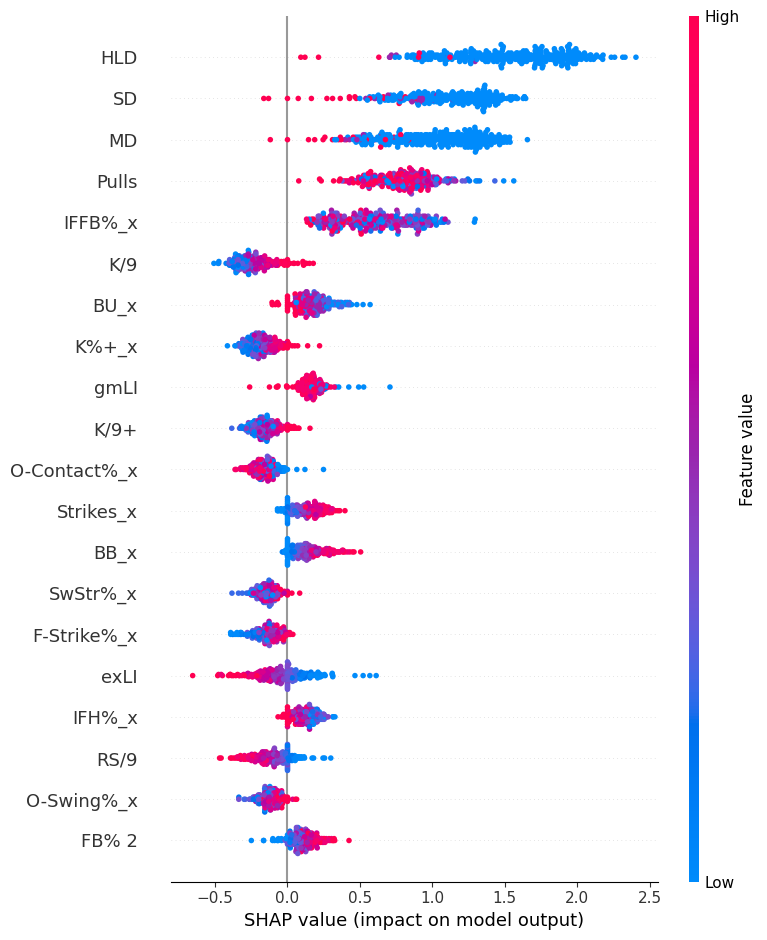

In [21]:
samples = shap.sample(X_train_transformed, 1)
e = shap.KernelExplainer(model, samples)
shap_values = e.shap_values(X_test_transformed[1:300])
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.summary_plot(shap_values[0], X_test_transformed[1:300], feature_names = colnames)

In [ ]:
data = data.drop(columns = ['HLD', 'SD',